Episode 0 : -210389.1673213051
Episode 1 : -190376.47558315194
Episode 2 : -190466.06602331082
Episode 3 : -180471.11533920062
Episode 4 : -180462.31746798495
Episode 5 : -200434.83391376628
Episode 6 : -160522.40346003216
Episode 7 : -200451.31462039152
Episode 8 : -200477.9713934841
Episode 9 : -190385.68192488083
Episode 10 : -190442.71625722386
Episode 11 : -130566.04173039985
Episode 12 : -190473.57747992495
Episode 13 : -170467.46231546183
Episode 14 : -160506.33107741468
Episode 15 : -180501.93374817804
Episode 16 : -190469.77165944292
Episode 17 : -190518.77363995698
Episode 18 : -190394.00588985032
Episode 19 : -200393.27989243044
Episode 20 : -210320.61161042625
Episode 21 : -190448.51074057876
Episode 22 : -210387.4328514472
Episode 23 : -170404.98950788987
Episode 24 : -160514.24321493768
Episode 25 : -160506.5208169531
Episode 26 : -200459.77696142276
Episode 27 : -180417.7347084312
Episode 28 : -160541.54797198137
Episode 29 : -150534.2311970358
Episode 30 : -210367.91234

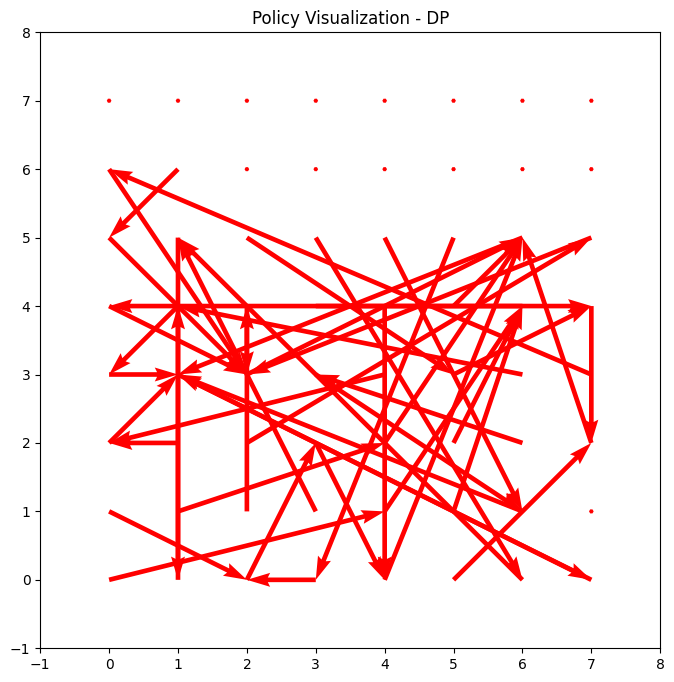

In [2]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring."""

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """
        Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max area for targets (size of the 2D grid).
            seed (int, optional): Random seed for reproducibility.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0  # Step counter
        self.num_targets: int = num_targets  # Number of targets
        self.max_steps: int = num_targets  # Max steps to visit all targets
        self.max_area: int = max_area  # Max area for the grid

        # Generate random target locations and distances between them
        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Define observation space (current location and distances) and action space
        self.obs_low = np.concatenate([np.array([0], dtype=np.float32), np.zeros(self.num_targets, dtype=np.float32), np.zeros(2 * self.num_targets, dtype=np.float32)])
        self.obs_high = np.concatenate([np.array([self.num_targets], dtype=np.float32), 2 * self.max_area * np.ones(self.num_targets, dtype=np.float32), self.max_area * np.ones(2 * self.num_targets, dtype=np.float32)])
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        """
        Reset the environment to the initial state (start from location 0).
        """
        self.steps: int = 0
        self.loc: int = 0  # Start location
        self.visited_targets: List = []  # List of visited targets
        self.dist: List = self.distances[self.loc]  # Distances from the current location
        state = np.concatenate([np.array([self.loc]), np.array(self.dist), np.array(self.locations).reshape(-1)], dtype=np.float32)
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """
        Take an action (move to the next target).
        
        Args:
            action (int): The index of the next target to move to.
        """
        self.steps += 1
        past_loc = self.loc  # Previous location
        next_loc = action  # Action specifies the next target to visit
        reward = self._get_rewards(past_loc, next_loc)  # Calculate reward based on the distance
        self.visited_targets.append(next_loc)  # Mark the next target as visited
        next_dist = self.distances[next_loc]  # Update distances from the new location
        terminated = bool(self.steps == self.max_steps)  # Termination if max steps are reached
        truncated = False
        next_state = np.concatenate([np.array([next_loc]), next_dist, np.array(self.locations).reshape(-1)], dtype=np.float32)
        self.loc, self.dist = next_loc, next_dist  # Update current location and distances
        return next_state, reward, terminated, truncated, {}

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations."""
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])
        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations."""
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])  # Euclidean distance
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate reward based on distance. Penalize revisiting targets."""
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000  # High penalty for revisiting targets
        return reward

    # 1. Dynamic Programming - Value Iteration
    def value_iteration(self, gamma=0.99, theta=1e-5):
        """
        Perform Value Iteration to find the optimal policy.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.

        Returns:
            V (np.ndarray): Optimal value function for each state.
            policy (np.ndarray): Optimal policy for each state.
        """
        V = np.zeros(self.num_targets)  # Initialize value function
        policy = np.zeros(self.num_targets, dtype=int)  # Initialize policy

        while True:
            delta = 0
            for state in range(self.num_targets):
                actions = []
                for action in range(self.num_targets):
                    if action != state:
                        next_state = action
                        reward = -self.distances[state, next_state]
                        actions.append(reward + gamma * V[next_state])
                best_action_value = max(actions)
                delta = max(delta, abs(V[state] - best_action_value))
                V[state] = best_action_value
                policy[state] = np.argmax(actions)

            if delta < theta:
                break  # Convergence condition
        return V, policy

    # Visualization for Policy
    def visualize_policy(self, policy, title="Policy Visualization"):
        """
        Visualize the policy using a quiver plot (arrows showing the next action from each location).

        Args:
            policy (np.ndarray): Policy to visualize.
            title (str): Title for the plot.
        """
        grid_size = int(np.ceil(np.sqrt(self.num_targets)))
        X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))

        U = np.zeros_like(X, dtype=float)  # Horizontal movements
        V = np.zeros_like(Y, dtype=float)  # Vertical movements

        for i in range(self.num_targets):
            row, col = divmod(i, grid_size)
            next_target = policy[i]
            next_row, next_col = divmod(next_target, grid_size)
            U[row, col] = next_col - col
            V[row, col] = next_row - row

        plt.figure(figsize=(8, 8))
        plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='r')
        plt.xlim(-1, grid_size)
        plt.ylim(-1, grid_size)
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    num_targets = 50  # Number of targets for TSP
    env = TSP(num_targets)

    # Run random episodes for testing
    obs = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # Random action
            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

    print(f"Average Return over 100 episodes: {np.mean(ep_rets)}")

    # Dynamic Programming (Value Iteration) Approach
    V_dp, policy_dp = env.value_iteration()
    print("Optimal Value Function (DP): ", V_dp)
    print("Optimal Policy (DP): ", policy_dp)
    env.visualize_policy(policy_dp, title="Policy Visualization - DP")
